### General steps to prepare data for xspec
    1) get complete_df with flags removed
    2) shift tus array in dataframe by tshift provided by cross_corrolate(). NOTE: ADDED to tus_ASIM
    3) use keV_bin() for binning of the energies
    4) change format of dataframe with this command: pd.set_option('display.float_format', '{:.6E}'.format)
    5) export to txt file with command: np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')



# imports

In [1]:
#%run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb #MAC
%run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb #UiB
pd.set_option('display.float_format', '{:.6E}'.format)

all UiB paths loaded
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
all UiB paths loaded
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


## ASIM

In [2]:
ASIM_df, T0_ASIM = complete_df(grb_id="GRB201227",remove_flag=True)
tus = ASIM_df["tus"].to_numpy()
print(T0_ASIM)

Creating df for short GRB
Absolute time correction subtracted from T0
35 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 42 flags
Removed 42 flags from df
df sorted by tus
2020-12-27 15:14:06.853667


5611
tus array OK ...


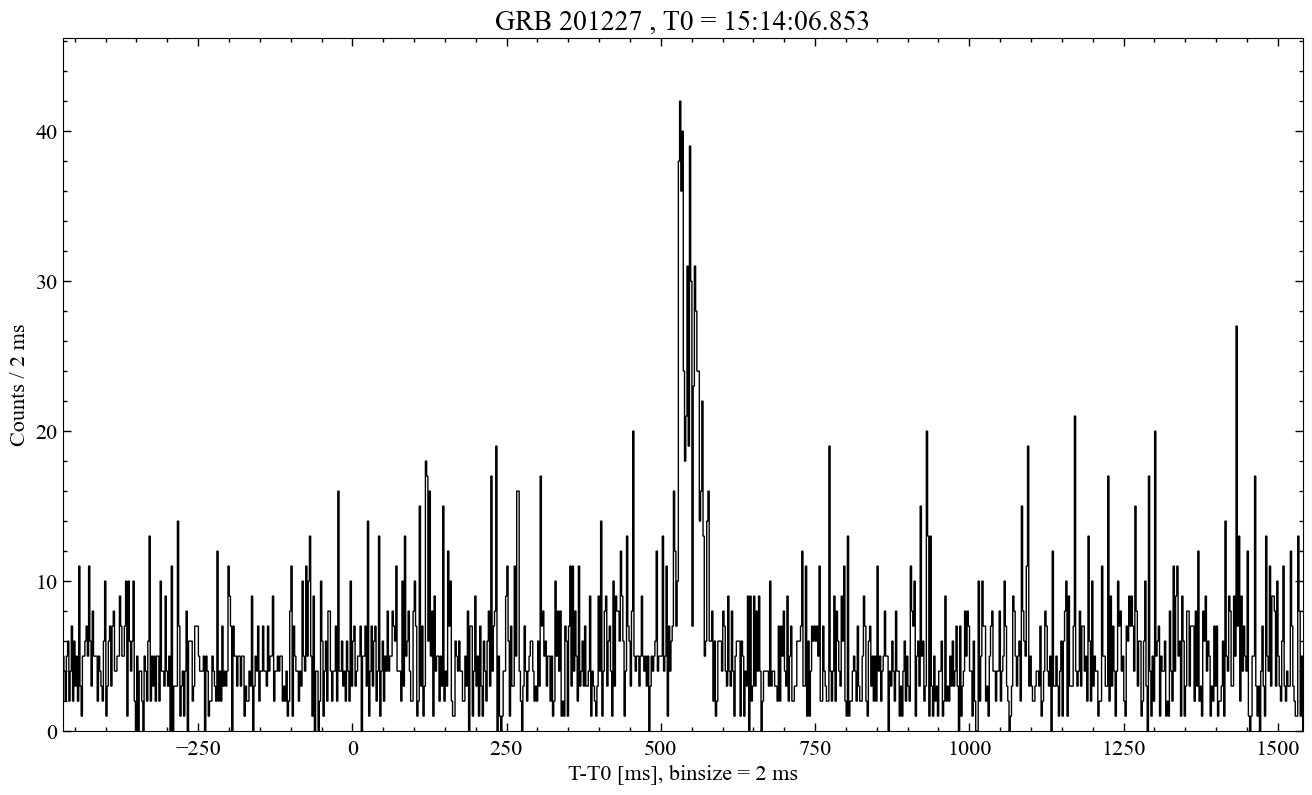

In [3]:
print(len(tus))
plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=2)

## KW

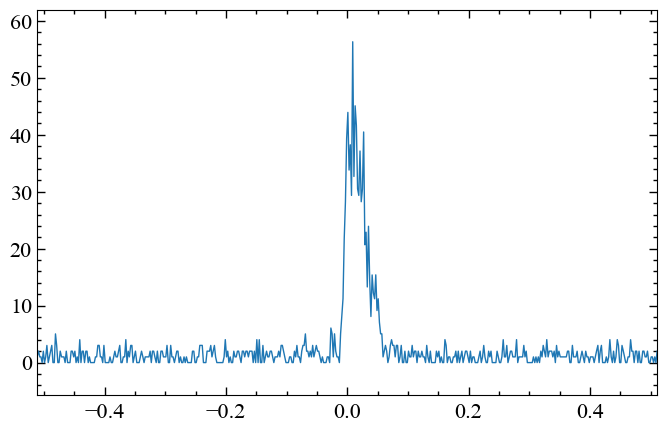

In [4]:
kw_filename = "GRB201227A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002
kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>binsize)[0][0]

kw_bin_lo, kw_bin_hi, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G2+G3
kw_lc = LC(time=kw_bin_lo + binsize/2, counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

# CrossCorr debugg
    TODO:
    - Switch lc1 and lc2. Hopefully tlagg is returned as ~0.5xx seconds
    if that doesnt work:
    - Change the time_lagg array that is used in the CC function. 

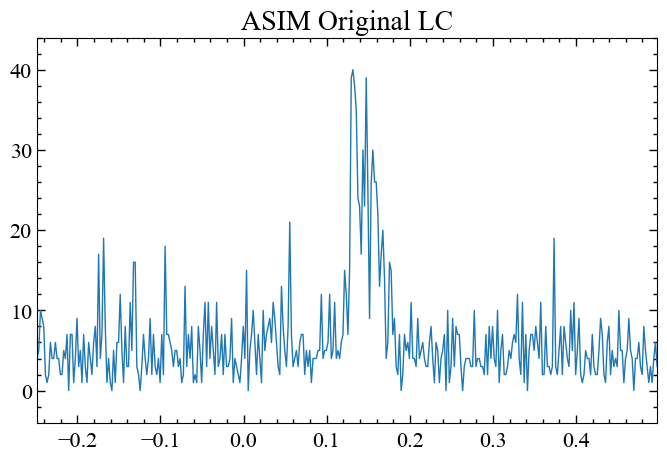

In [5]:
tus = ASIM_df["tus"].to_numpy(dtype=np.float32)/1e6
laggApprox = -0.4
tus += laggApprox
tus = tus[find_nearest(tus,-0.25):find_nearest(tus,0.5)]
lc1 = LC.make_lightcurve(toa=tus,dt=0.002)
lc1.plot(title="ASIM Original LC")

In [6]:
#tshift (s)  0.492 ---> lc1=asim, lc2=kw, full, dt= 0.002. Problem is that the value is returned positive
#Estimated tlagg = -0.54 (by eye)
#CC estimates -0.4 -0.132 = -0.532

-0.132


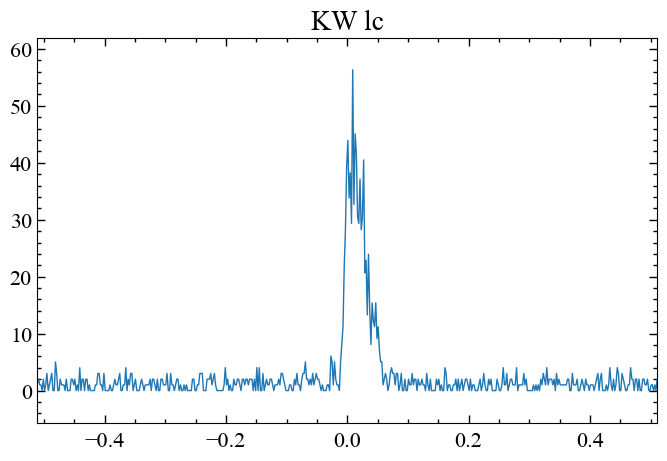

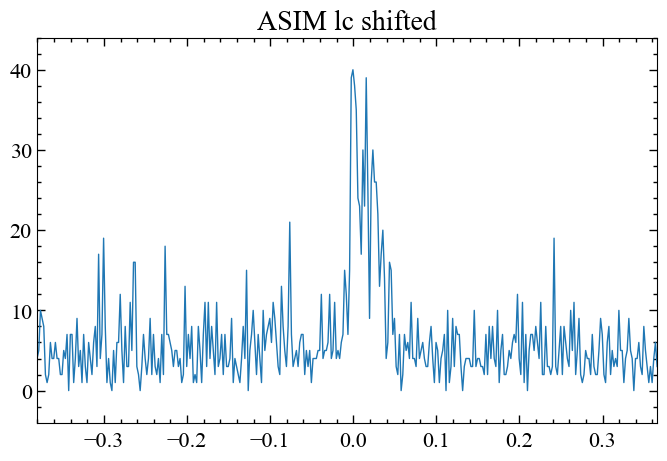

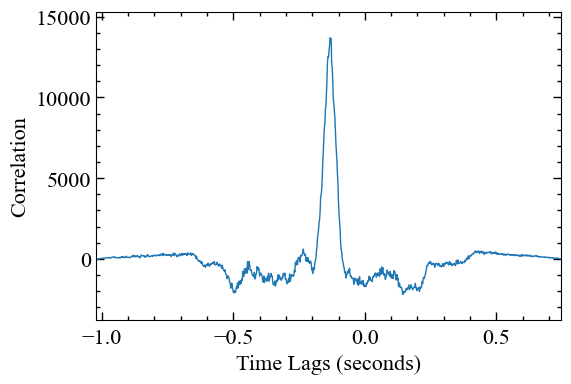

tshift (s)  -0.132  returned as s


In [7]:
CC = CrossCorrelation(lc1,kw_lc,mode="full")
tlagg = np.round(CC.cal_timeshift(dt=0.002)[0],6)
print(CC.time_shift)
lc1Shifted = lc1.shift(CC.time_shift) #t_shift is added to lightcurve. Checked in source code

#Plotting ---------------------------------

kw_lc.plot(title="KW lc")
#lc1.plot(title="ASIM lc")
lc1Shifted.plot(title="ASIM lc shifted")
CC.plot(labels = ['Time Lags (seconds)','Correlation'])

print("tshift (s) ", tlagg, " returned as s")

In [8]:
#Good estimation of -0.532 s when ASIM tus is first centered around 0. If entire tus is passed to be corolated, it will not return a good result
# Shift tus by tlagg and extract the spectrum for T0-T0+64ms

In [9]:
tus = ASIM_df["tus"].to_numpy()
tusShifted= tus-0.532*1e6

In [10]:
tusShifted

array([-1001628.27777778, -1001628.27777778, -1001238.19444444, ...,
        1007134.86111111,  1007223.77777778,  1007352.30555556])

tus array OK ...


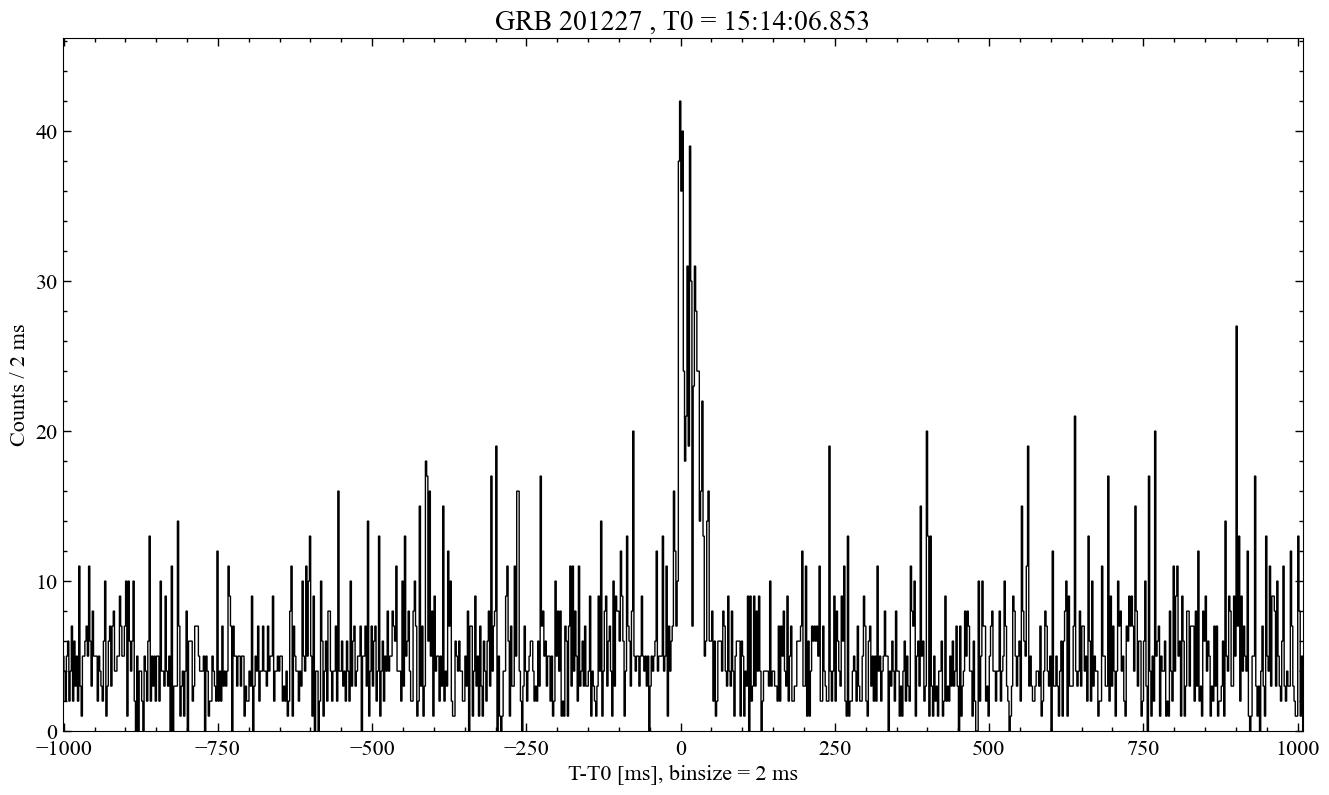

In [11]:
plot_HED(tus_arr=tusShifted,T0=T0_ASIM,binsize=2)

In [12]:
ASIM_df["tus"] = tusShifted
ASIM_df.head()

,tus,erg,typ,adr,dau,det,keV,cal_abc,st,dt,flag
1,-1.001628E+06,44,0,8,3,2,1.239455E+03,"-0.006079, 29.0395, -26.5145",1.159636E+00,NaN,False
0,-1.001628E+06,27,0,2,1,2,5.542465E+02,"-0.001833, 20.5554, 0.586966",1.108493E+00,NaN,False
3,-1.001238E+06,1595,0,4,2,1,2.723717E+04,"0.006808, 6.1533, 102.9379",2.300000E+01,NaN,False
2,-1.001238E+06,1805,0,3,1,3,2.857945E+04,"0.002741, 10.8712, 26.6903",2.300000E+01,NaN,False
4,-1.000963E+06,167,0,8,3,2,4.653545E+03,"-0.006079, 29.0395, -26.5145",3.614179E+00,6.657500E+02,False


In [13]:
keV_df = keV_hist(df=ASIM_df,time_interval=(0,0.064),
                 keV_interval="max",
                 duration=0.064,
                 )
#All triggers in the time_interval are kept

Computing whole spectrum (10-1e5 keV)
n triggers in time interval  551
n triggers are within bounds  551
keV bins are set for HED
Energies binned!


In [14]:
#np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB201227A/ASIM201227.txt',keV_df.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')

In [15]:
keV_df

,bins_keV,counts,poisson_error_counts,duration_seconds
0,1.000000E+01,-9.999000E+03,-9.999000E+03,-9.999000E+03
1,1.258925E+01,0.000000E+00,0.000000E+00,6.400000E-02
2,1.584893E+01,0.000000E+00,0.000000E+00,6.400000E-02
3,1.995262E+01,0.000000E+00,0.000000E+00,6.400000E-02
4,2.511886E+01,0.000000E+00,0.000000E+00,6.400000E-02
5,3.162278E+01,0.000000E+00,0.000000E+00,6.400000E-02
6,3.981072E+01,0.000000E+00,0.000000E+00,6.400000E-02
7,5.011872E+01,0.000000E+00,0.000000E+00,6.400000E-02
8,6.309573E+01,0.000000E+00,0.000000E+00,6.400000E-02
9,7.943282E+01,0.000000E+00,0.000000E+00,6.400000E-02


### bakground extraction 

plot_HED(tus_arr=tus,T0=T0_ASIM,binsize=2)

In [16]:
#From KW lc it looks like there is a precoursor that starts around T0-0.06s in the low energy band

keV_bg = keV_hist(df=ASIM_df,time_interval=(-1,-0.1),
                 keV_interval="max",
                 duration=0.9,
                 )

In [17]:
#np.savetxt(r'/Home/siv30/wad005/master/GRB/xspec/GRB201227A/ASIM201227_bg.txt',keV_bg.values, delimiter=',', header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')